# 0.0 initial configurations

## 0.1 imports


In [188]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error

## 0.2 helpers functions

In [189]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [190]:
# MAE
def metrics(y_true, y_pred,model_name):
    y_true = y_true.values
    y_pred = y_pred.values
    mae = round(mean_absolute_error(y_true, y_pred),0)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),0)
    mape = round(mean_absolute_percentage_error(y_true, y_pred),0)
    metrics = pd.DataFrame({'Model': model_name,'mae': mae, 'rmse': rmse, 'mape': mape}, index=[0])
    return metrics

## 0.3 load data

In [191]:
path = '/home/lavino/Documentos/projetos_pessoais/forecast_course/'

In [192]:
data = pd.read_csv(path + '/data/Daily Bike Sharing.csv',
            index_col='dteday',
            parse_dates=True)

In [193]:
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [194]:
cols = [
    "cnt",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
]
df1  = data.loc[:,cols].rename(columns={"cnt":"y"})
df1.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [195]:
df1 = df1.asfreq("D")

In [196]:
df1.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

<Axes: xlabel='dteday'>

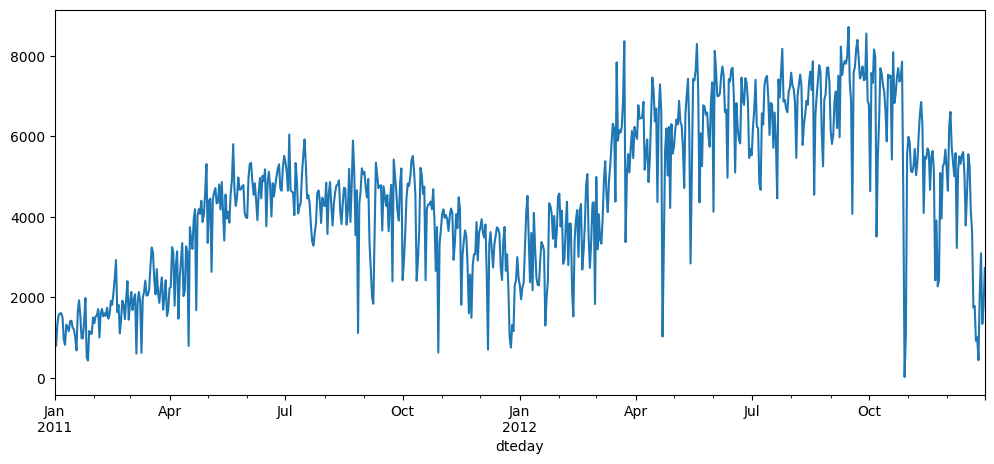

In [197]:
df1['y'].plot(figsize=(12, 5))

# 1.0 season analysis

## 1.1 seasonality decomposition

In [198]:
from statsmodels.tsa.seasonal import seasonal_decompose

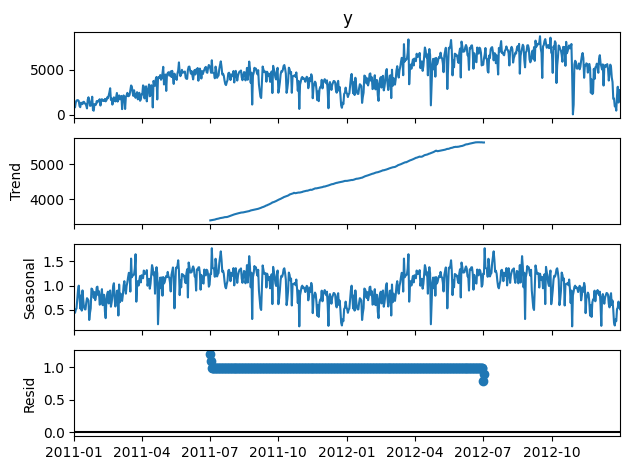

In [199]:
decomposition = seasonal_decompose(x = df1['y'], model='multiplicative', period=365)
decomposition.plot();

## 1.2 seasonality graphs

In [200]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

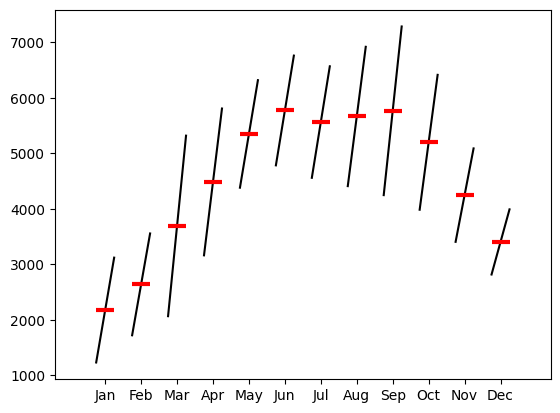

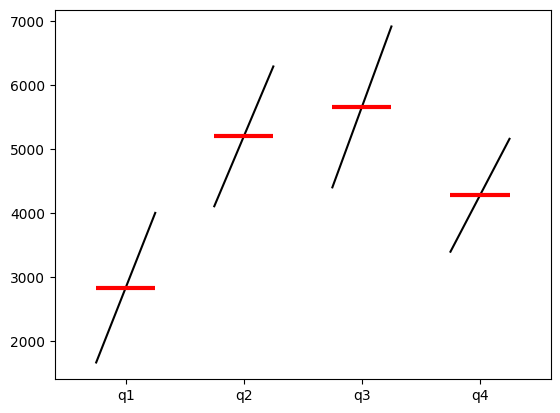

In [201]:
month_plot(df1.y.resample('MS').mean());
quarter_plot(df1.y.resample('Q').mean());

# 2.0 Models

## 2.1 train and test split

In [202]:
# split train and test
test_days = 31
train = df1.iloc[:-test_days,:]
test = df1.iloc[-test_days:,:]


<Axes: xlabel='dteday'>

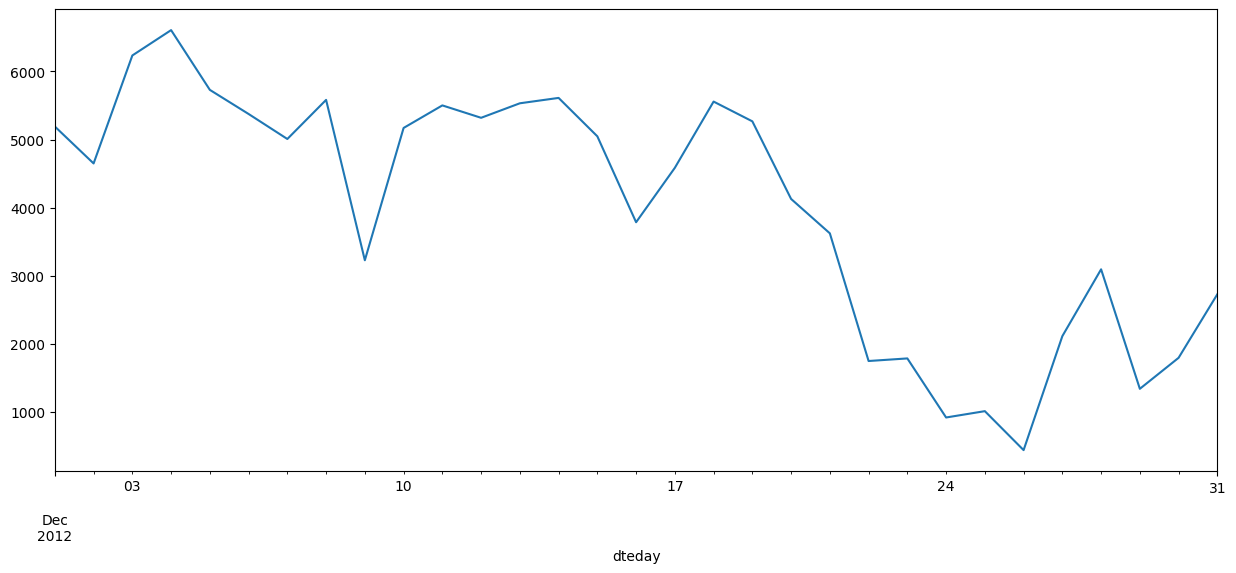

In [203]:
test['y'].plot(figsize=(15, 6))

## 2.2 Exponencial smoothing

In [204]:
# exponential smoting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [205]:
model = ExponentialSmoothing(endog=train.y,
                                trend='mul',
                                seasonal='mul',
                                seasonal_periods=7).fit()

/home/lavino/Documentos/projetos_pessoais/forecast_course/venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [206]:
pred_hotwin = model.forecast(steps=len(test))

<Axes: xlabel='dteday'>

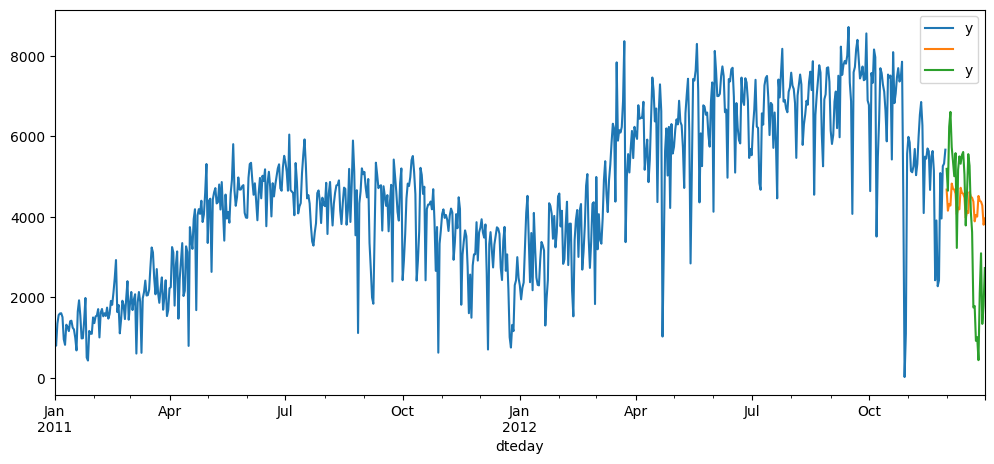

In [207]:
train.y.plot(figsize=(12, 5),legend=True)
pred_hotwin.plot(figsize=(12, 5),legend=True)
test.y.plot(figsize=(12, 5),legend=True)

### 2.2.1 Metrics

In [208]:
metrics_hotwin = metrics(test.y, pred_hotwin, 'Hot-winters')
metrics_hotwin

,Model,mae,rmse,mape
0,Hot-winters,1389.0,1698.0,87.0


## 2.3 TBATS - Trigonometric Seasonality with Box-cox_transformations

In [209]:
from tbats import TBATS, BATS

In [210]:
model = TBATS(
    use_trend=True,
    seasonal_periods=[7,365.5]
)

model = model.fit(train['y'])


In [211]:
pred_tbats = pd.Series(model.forecast(steps = len(test))).rename('TBATS')
pred_tbats.index = test.index
pred_tbats.head()

dteday
2012-12-01    4828.272249
2012-12-02    4482.064414
2012-12-03    4362.513961
2012-12-04    4305.123489
2012-12-05    4260.338328
Freq: D, Name: TBATS, dtype: float64

<Axes: xlabel='dteday'>

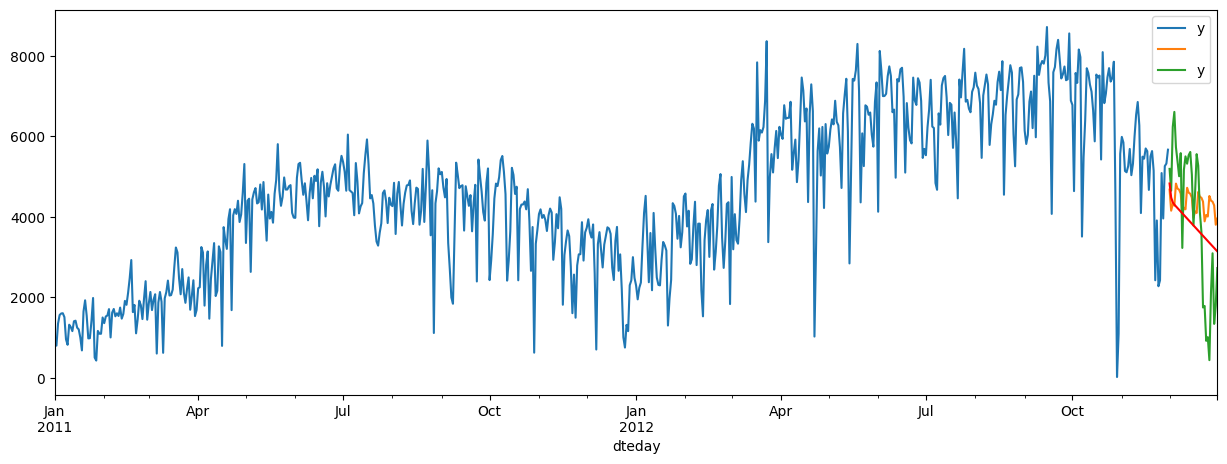

In [212]:
train.y.plot(figsize=(12, 5),legend=True)
pred_hotwin.plot(figsize=(12, 5),legend=True)
test.y.plot(figsize=(12, 5),legend=True)
pred_tbats.plot(figsize=(15, 5), color='red', label='T-BATS')

In [213]:
metrics_tbats = metrics(test.y, pred_tbats, 'T-BATS')
metrics_tbats

,Model,mae,rmse,mape
0,T-BATS,1299.0,1494.0,68.0


## 2.4 Sarimax

In [214]:
from pmdarima import auto_arima

In [215]:
## exogenous variables
train_exog = train.iloc[:, 1:]
test_exog = test.iloc[:, 1:]

In [216]:
train_exog

,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900
...,...,...,...,...,...,...,...
2012-11-26,0,1,1,0.313333,0.339004,0.535417,0.046650
2012-11-27,0,1,2,0.291667,0.281558,0.786667,0.237562
2012-11-28,0,1,1,0.296667,0.289762,0.506250,0.210821


In [217]:
model = auto_arima(y = train['y'],
                    X = train_exog,
                    m = 7,
                    seasonal = True,
                    stepwise=False
)

In [218]:
train_exog

,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900
...,...,...,...,...,...,...,...
2012-11-26,0,1,1,0.313333,0.339004,0.535417,0.046650
2012-11-27,0,1,2,0.291667,0.281558,0.786667,0.237562
2012-11-28,0,1,1,0.296667,0.289762,0.506250,0.210821


In [219]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -5596.921
Date:                Tue, 22 Aug 2023   AIC                          11217.842
Time:                        14:16:15   BIC                          11272.438
Sample:                    01-01-2011   HQIC                         11238.948
                         - 11-30-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3363      5.562      0.780      0.436      -6.566      15.238
holiday     -240.2429    129.114     -1.861      0.063    -493.301      12.815
workingday    89.1769     60.525      1.473      0.141     -29.450     207.804
weathersit  -460.2189     51.306     -8.970      0.000    -560.776    -359.662
temp        3421.6063   1170.580      2.923      0.003    1127.312    5715.900
atemp       1970.5757   1197.166      1.646      0.100    -375.827    4316.978
hum        -2280.4183    198.526    -11.487      0.000   -2669.522   -1891.315
windspeed  -2275.5667    373.391     -6.094      0.000   -3007.399   -1543.734
ma.L1         -0.5546      0.028    -19.642      0.000      -0.610      -0.499
ma.L2         -0.1348      0.039     -3.422      0.001      -0.212      -0.058
ma.L3         -0.1443      0.040     -3.607      0.000      -0.223      -0.066
sigma2      5.263e+05   2.02e+04     26.106      0.000    4.87e+05    5.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               623.72
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
pred_sarimax = model.predict(n_periods=test_days, X= test_exog).rename("SARIMAX Predictions")
pred_sarimax

2012-12-01    4288.793634
2012-12-02    4216.809763
2012-12-03    5448.119336
2012-12-04    5427.376509
2012-12-05    5448.690983
2012-12-06    4779.471672
2012-12-07    4189.643317
2012-12-08    4177.148691
2012-12-09    4075.809920
2012-12-10    4317.391732
2012-12-11    4356.025063
2012-12-12    4524.383774
2012-12-13    5071.281646
2012-12-14    4766.559922
2012-12-15    4953.729999
2012-12-16    4274.472687
2012-12-17    4385.503534
2012-12-18    5195.085035
2012-12-19    4976.314384
2012-12-20    4518.759547
2012-12-21    4148.967292
2012-12-22    4375.008966
2012-12-23    4811.913793
2012-12-24    3892.328878
2012-12-25    3763.312487
2012-12-26    2788.323712
2012-12-27    3614.571243
2012-12-28    4258.469574
2012-12-29    3847.933000
2012-12-30    4399.599012
2012-12-31    4110.906233
Freq: D, Name: SARIMAX Predictions, dtype: float64

<Axes: xlabel='dteday'>

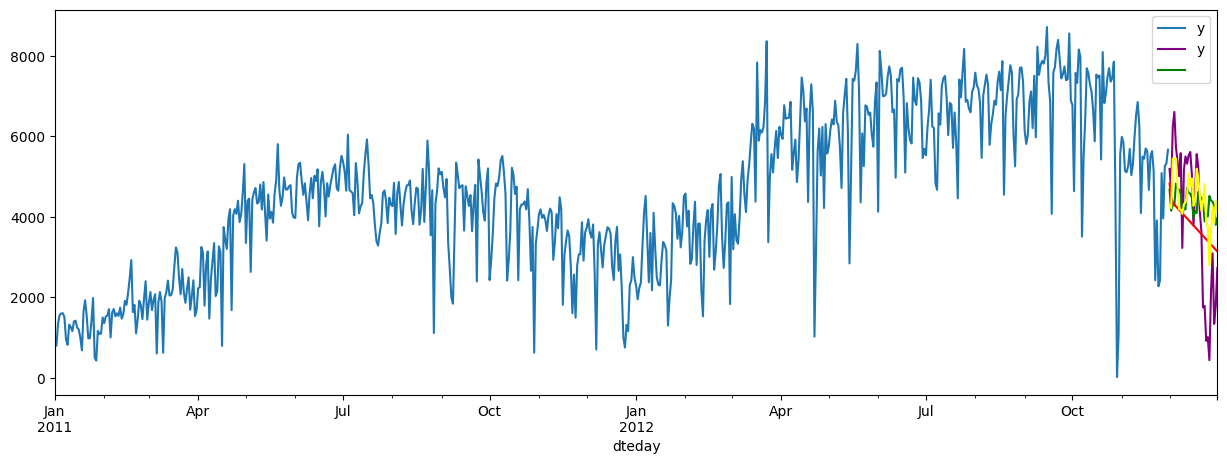

In [221]:
train.y.plot(figsize=(12, 5),legend=True)
test.y.plot(figsize=(12, 5),legend=True,color = 'purple')
pred.plot(figsize=(12, 5),legend=True, color='green')
pred_tbats.plot(figsize=(15, 5), color='red', label='T-BATS')
pred_sarimax.plot(figsize=(15, 5), color='yellow', label='SARIMAX')

<Axes: >

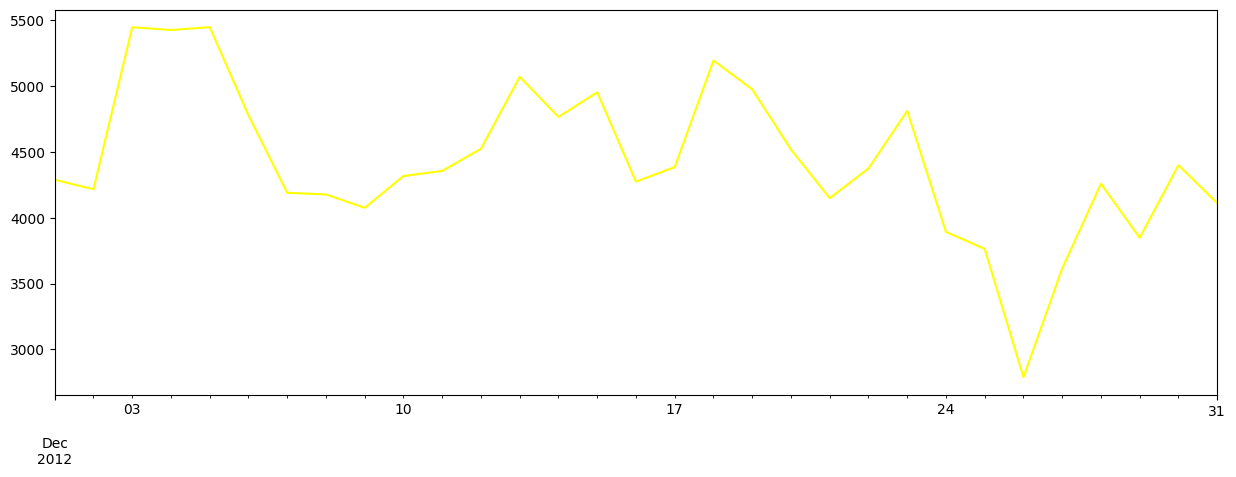

In [222]:
pred_sarimax.plot(figsize=(15, 5), color='yellow', label='SARIMAX')

### 2.4.1 Metrics

In [223]:
metrics_sarimax = metrics(test.y, pred_sarimax, 'SARIMAX')
metrics_sarimax

,Model,mae,rmse,mape
0,SARIMAX,1180.0,1480.0,71.0


## 2.5 Facebook Prophet

In [224]:
import itertools
from prophet import Prophet

In [225]:
data = pd.read_csv(path + '/data/Daily Bike Sharing.csv')

In [226]:
cols = [
    'dteday',
    'cnt',
    'holiday',
    'workingday',
    'weathersit',
    'temp',
    'atemp',
    'hum',
    'windspeed',
]
df2 = (
    data.loc[:,cols].rename(
        columns = {
                    'cnt':'y',
                    'dteday':'ds'
                }
    ).copy()
)

In [227]:
df2['ds'] = pd.to_datetime(df2['ds'],format='%Y-%m-%d')

In [228]:
test_days = 31
train = df2.iloc[:-test_days,:]
test = df2.iloc[-test_days:,:]

In [229]:
holidays_date = df2[df2['holiday'] == 1]['ds']
holidays = pd.DataFrame({'holiday': 'holi',
                         'ds': pd.to_datetime(holidays_date),
                         'lower_window': -3,
                         'upper_window': 1})
holidays

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1
247,holi,2011-09-05,-3,1
282,holi,2011-10-10,-3,1
314,holi,2011-11-11,-3,1
327,holi,2011-11-24,-3,1
359,holi,2011-12-26,-3,1


In [230]:
df2 = df2.drop(['holiday'], axis=1)

In [231]:
df2

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900
...,...,...,...,...,...,...,...,...
726,2012-12-27,2114,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,3095,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,1341,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,1796,0,1,0.255833,0.231700,0.483333,0.350754


In [232]:
model_pro = Prophet(growth='linear',
                    holidays=holidays,
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    seasonality_mode='multiplicative',
                    seasonality_prior_scale=10,
                    holidays_prior_scale=10,
                    changepoint_prior_scale=0.05,
)
model_pro.add_regressor('workingday')
model_pro.add_regressor('weathersit')
model_pro.add_regressor('temp')
model_pro.add_regressor('atemp')
model_pro.add_regressor('windspeed')
model_pro.add_regressor('hum')
model_pro.fit(train)

14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing


In [233]:
future = model_pro.make_future_dataframe(periods=test_days,
                                         freq='D')
future.head()

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


In [234]:
future = pd.concat([future, df2.iloc[:,2:]], axis=1)
future.head()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1,1,0.226957,0.229270,0.436957,0.186900


In [235]:
forecast = model_pro.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,daily,daily_lower,daily_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,738.285807,-6.651728,1788.761622,738.285807,738.285807,-0.094853,-0.094853,-0.094853,1.18382,1.18382,1.18382,-0.629621,-0.629621,-0.629621,0.0,0.0,0.0,0.0,0.0,0.0,-0.162950,-0.162950,-0.162950,0.215405,0.215405,0.215405,-0.230083,-0.230083,-0.230083,-0.187601,-0.187601,-0.187601,0.230829,0.230829,0.230829,0.045866,0.045866,0.045866,0.00000,0.00000,0.00000,-0.569624,-0.569624,-0.569624,0.0,0.0,0.0,897.316070
1,2011-01-02,743.659578,-144.876072,1690.645205,743.659578,743.659578,-0.102837,-0.102837,-0.102837,1.18382,1.18382,1.18382,-0.643950,-0.643950,-0.643950,0.0,0.0,0.0,0.0,0.0,0.0,-0.063806,-0.063806,-0.063806,-0.007982,-0.007982,-0.007982,-0.202113,-0.202113,-0.202113,-0.187601,-0.187601,-0.187601,0.005395,0.005395,0.005395,-0.087593,-0.087593,-0.087593,0.00000,0.00000,0.00000,-0.553247,-0.553247,-0.553247,0.0,0.0,0.0,737.723600
2,2011-01-03,749.033348,89.191360,1801.481072,749.033348,749.033348,-0.235547,-0.235547,-0.235547,1.18382,1.18382,1.18382,-0.267723,-0.267723,-0.267723,0.0,0.0,0.0,0.0,0.0,0.0,0.170006,0.170006,0.170006,0.281106,0.281106,0.281106,-0.444155,-0.444155,-0.444155,0.117087,0.117087,0.117087,-0.100931,-0.100931,-0.100931,-0.087244,-0.087244,-0.087244,0.21213,0.21213,0.21213,-0.534060,-0.534060,-0.534060,0.0,0.0,0.0,959.591273
3,2011-01-04,754.407119,125.683917,1879.392968,754.407119,754.407119,-0.217202,-0.217202,-0.217202,1.18382,1.18382,1.18382,-0.249139,-0.249139,-0.249139,0.0,0.0,0.0,0.0,0.0,0.0,0.031640,0.031640,0.031640,0.383487,0.383487,0.383487,-0.438889,-0.438889,-0.438889,0.117087,0.117087,0.117087,-0.038886,-0.038886,-0.038886,0.046094,0.046094,0.046094,0.21213,0.21213,0.21213,-0.512307,-0.512307,-0.512307,0.0,0.0,0.0,1043.712657
4,2011-01-05,759.780889,280.823635,2061.788554,759.780889,759.780889,-0.203353,-0.203353,-0.203353,1.18382,1.18382,1.18382,-0.097901,-0.097901,-0.097901,0.0,0.0,0.0,0.0,0.0,0.0,0.170291,0.170291,0.170291,0.543909,0.543909,0.543909,-0.399845,-0.399845,-0.399845,0.117087,0.117087,0.117087,-0.053729,-0.053729,-0.053729,0.005789,0.005789,0.005789,0.21213,0.21213,0.21213,-0.488280,-0.488280,-0.488280,0.0,0.0,0.0,1173.032894


<Axes: >

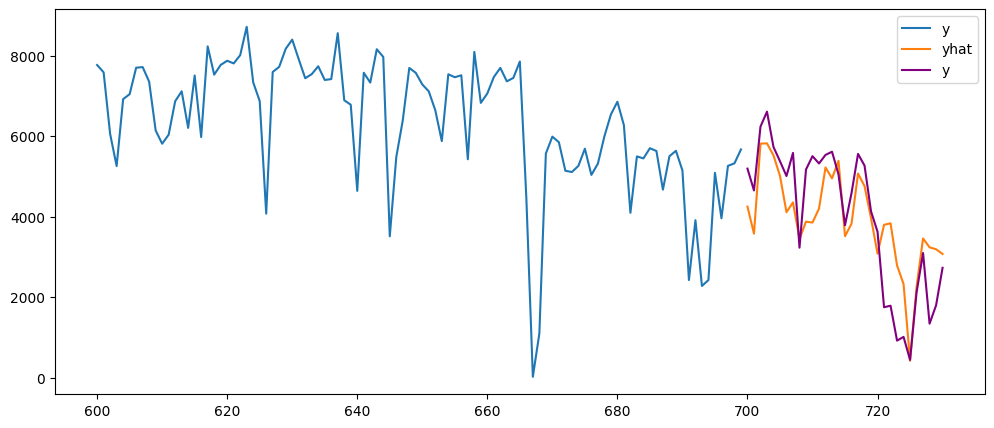

In [236]:
pred_prophet = forecast.yhat[-test_days:]
train.loc[600:,'y'].plot(figsize=(12, 5),legend=True)
pred_prophet.plot(figsize=(12, 5),legend=True)
test.loc[600:,'y'].plot(figsize=(12, 5),legend=True,color = 'purple')
# pred.plot(figsize=(12, 5),legend=True, color='green')
# pred_tbats.plot(figsize=(15, 5), color='red', label='T-BATS')
# pred_sarimax.plot(figsize=(15, 5), color='yellow', label='SARIMAX')

### 2.5.1 Metrics

In [237]:
metrics_prophet = metrics(test.y, pred_prophet, 'Prophet')
metrics_prophet

,Model,mae,rmse,mape
0,Prophet,829.0,1025.0,35.0


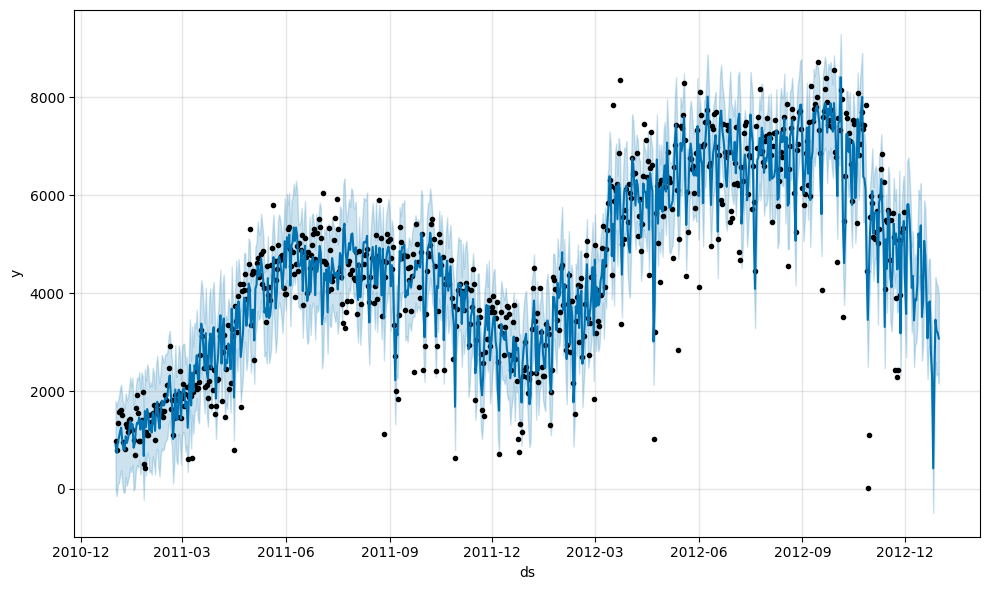

In [238]:
model_pro.plot(forecast);

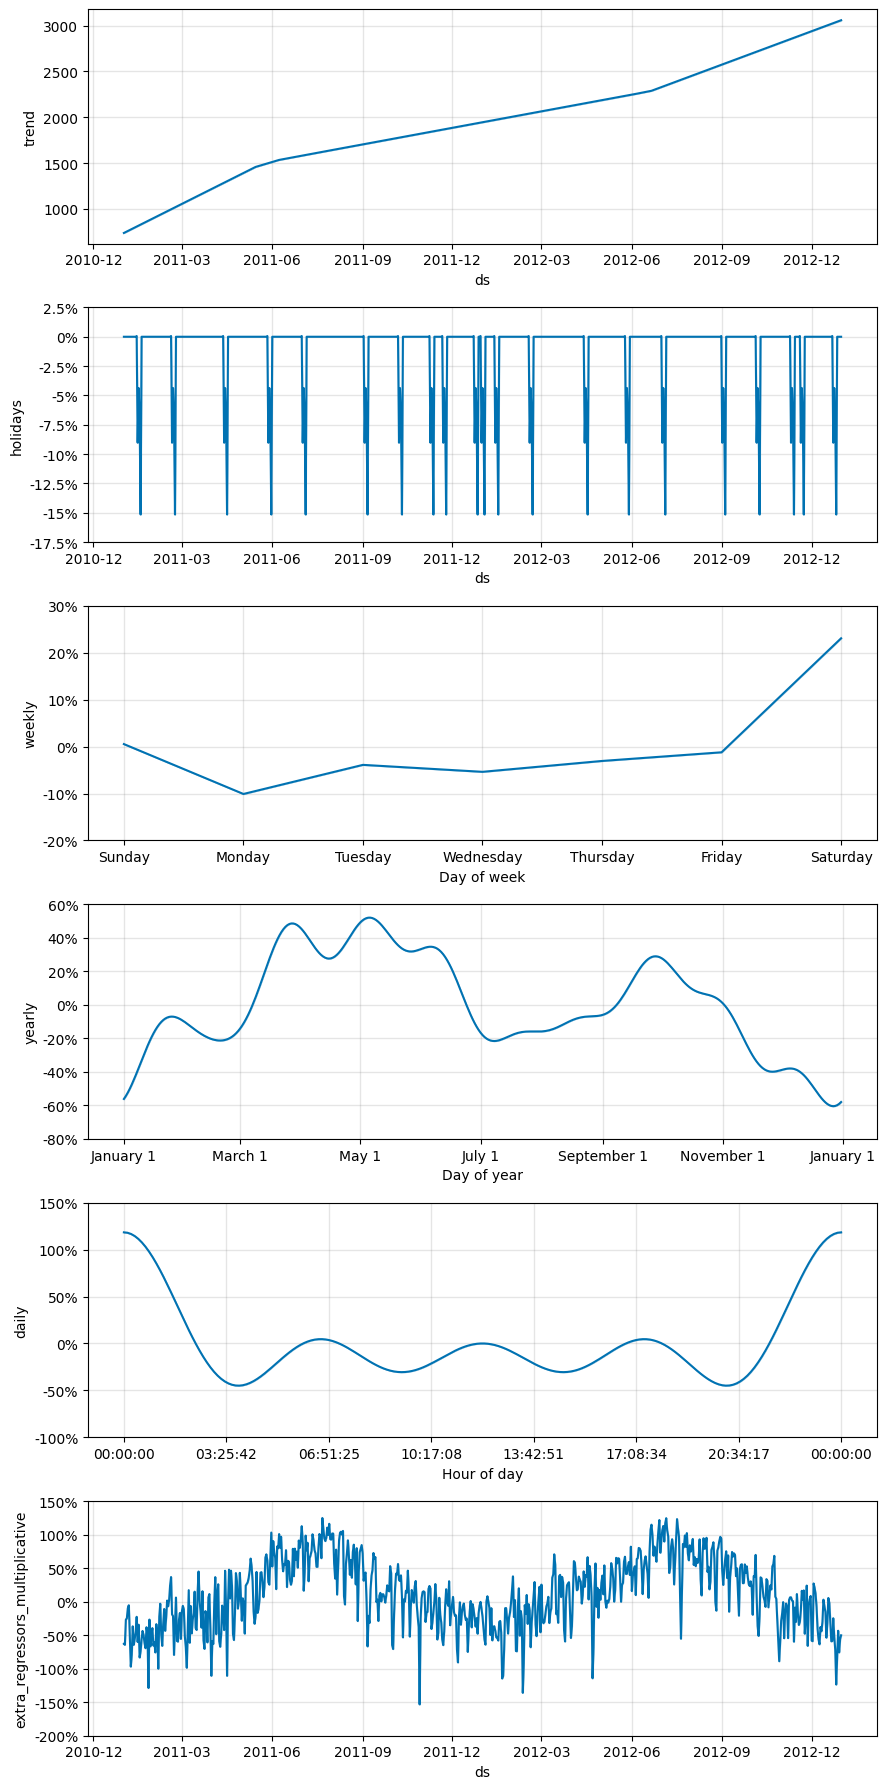

In [239]:
model_pro.plot_components(forecast);

### 2.5.2 Cross validation

In [240]:
# cross validation phophet
from prophet.diagnostics import cross_validation

In [241]:
df_c = cross_validation(model_pro, horizon='31 days',initial='540 days', parallel='processes')

14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1]

In [242]:
df_c.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8038.164692,7274.419683,8764.312587,5463,2012-06-28
1,2012-06-30,7154.812028,6318.472075,7872.884064,5687,2012-06-28
2,2012-07-01,7347.183803,6591.390672,8073.973439,5531,2012-06-28
3,2012-07-02,6672.316066,5927.028968,7467.597821,6227,2012-06-28
4,2012-07-03,7334.020188,6560.966863,8091.545277,6660,2012-06-28


In [243]:
metrics_prophet_cv = metrics(df_c.y, df_c.yhat, 'Prophet CV')
metrics_prophet_cv

,Model,mae,rmse,mape
0,Prophet CV,1009.0,1298.0,131.0


### 2.5.3 Hyperparameter tunning

In [245]:
# parameters grid
from sklearn.model_selection import ParameterGrid

param_grid = {
    'seasonality_prior_scale': [5, 10, 20],
    'holidays_prior_scale': [5, 10, 20],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
}

grid = ParameterGrid(param_grid)


In [246]:
# hyper parameter tuning
df_metric = pd.DataFrame()

for params in grid:
    # biuld model
    model_pro = Prophet(growth='linear',
                    holidays=holidays,
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    seasonality_mode='multiplicative',
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays_prior_scale=params['holidays_prior_scale'],
                    changepoint_prior_scale=params['changepoint_prior_scale'],
    )
    
    model_pro.add_regressor('workingday')
    model_pro.add_regressor('weathersit')
    model_pro.add_regressor('temp')
    model_pro.add_regressor('atemp')
    model_pro.add_regressor('windspeed')
    model_pro.add_regressor('hum')
    model_pro.fit(train)
    
    # cross - validation
    
    df_c = cross_validation(
        model_pro, 
        horizon='31 days',
        initial='540 days', 
        parallel='processes'
    )
    
    #gather metrics
    
    mae = round(mean_absolute_error(df_c['y'],df_c['yhat']))
    rmse = round(np.sqrt(mean_squared_error(df_c['y'],df_c['yhat'])))
    mape = round(mean_absolute_percentage_error(df_c['y'],df_c['yhat']))
    
    metric = pd.DataFrame({
        'mae':mae,
        'rmse':rmse,
        'mape':mape,
        'params':str(params)
        },index=[0]
    )
    
    df_metric = pd.concat([df_metric,metric],axis=0)
    
df_metric.reset_index(drop=True,inplace=True)

14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done processing


14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing
14:16:25 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1]

In [247]:
print(df_metric.sort_values(by=['mae','rmse','mape'],ascending=True).head(1)['params'].values)

["{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 20, 'seasonality_prior_scale': 20}"]


## 2.6 Prophet + XGBoost

In [248]:
# show all columns
pd.set_option('display.max_columns', None)

In [249]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,daily,daily_lower,daily_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,738.285807,-6.651728,1788.761622,738.285807,738.285807,-0.094853,-0.094853,-0.094853,1.18382,1.18382,1.18382,-0.629621,-0.629621,-0.629621,0.0,0.0,0.0,0.0,0.0,0.0,-0.162950,-0.162950,-0.162950,0.215405,0.215405,0.215405,-0.230083,-0.230083,-0.230083,-0.187601,-0.187601,-0.187601,0.230829,0.230829,0.230829,0.045866,0.045866,0.045866,0.00000,0.00000,0.00000,-0.569624,-0.569624,-0.569624,0.0,0.0,0.0,897.316070
1,2011-01-02,743.659578,-144.876072,1690.645205,743.659578,743.659578,-0.102837,-0.102837,-0.102837,1.18382,1.18382,1.18382,-0.643950,-0.643950,-0.643950,0.0,0.0,0.0,0.0,0.0,0.0,-0.063806,-0.063806,-0.063806,-0.007982,-0.007982,-0.007982,-0.202113,-0.202113,-0.202113,-0.187601,-0.187601,-0.187601,0.005395,0.005395,0.005395,-0.087593,-0.087593,-0.087593,0.00000,0.00000,0.00000,-0.553247,-0.553247,-0.553247,0.0,0.0,0.0,737.723600
2,2011-01-03,749.033348,89.191360,1801.481072,749.033348,749.033348,-0.235547,-0.235547,-0.235547,1.18382,1.18382,1.18382,-0.267723,-0.267723,-0.267723,0.0,0.0,0.0,0.0,0.0,0.0,0.170006,0.170006,0.170006,0.281106,0.281106,0.281106,-0.444155,-0.444155,-0.444155,0.117087,0.117087,0.117087,-0.100931,-0.100931,-0.100931,-0.087244,-0.087244,-0.087244,0.21213,0.21213,0.21213,-0.534060,-0.534060,-0.534060,0.0,0.0,0.0,959.591273
3,2011-01-04,754.407119,125.683917,1879.392968,754.407119,754.407119,-0.217202,-0.217202,-0.217202,1.18382,1.18382,1.18382,-0.249139,-0.249139,-0.249139,0.0,0.0,0.0,0.0,0.0,0.0,0.031640,0.031640,0.031640,0.383487,0.383487,0.383487,-0.438889,-0.438889,-0.438889,0.117087,0.117087,0.117087,-0.038886,-0.038886,-0.038886,0.046094,0.046094,0.046094,0.21213,0.21213,0.21213,-0.512307,-0.512307,-0.512307,0.0,0.0,0.0,1043.712657
4,2011-01-05,759.780889,280.823635,2061.788554,759.780889,759.780889,-0.203353,-0.203353,-0.203353,1.18382,1.18382,1.18382,-0.097901,-0.097901,-0.097901,0.0,0.0,0.0,0.0,0.0,0.0,0.170291,0.170291,0.170291,0.543909,0.543909,0.543909,-0.399845,-0.399845,-0.399845,0.117087,0.117087,0.117087,-0.053729,-0.053729,-0.053729,0.005789,0.005789,0.005789,0.21213,0.21213,0.21213,-0.488280,-0.488280,-0.488280,0.0,0.0,0.0,1173.032894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,3042.417754,1336.638846,3142.393601,3038.532621,3047.340112,-0.205476,-0.205476,-0.205476,1.18382,1.18382,1.18382,-0.807694,-0.807694,-0.807694,0.0,0.0,0.0,0.0,0.0,0.0,-0.024806,-0.024806,-0.024806,-0.259276,-0.259276,-0.259276,-0.360435,-0.360435,-0.360435,-0.187601,-0.187601,-0.187601,-0.030561,-0.030561,-0.030561,-0.241505,-0.241505,-0.241505,0.21213,0.21213,0.21213,-0.604841,-0.604841,-0.604841,0.0,0.0,0.0,2253.592766
727,2012-12-28,3046.405241,2600.991108,4326.648872,3042.087363,3051.707434,-0.182538,-0.182538,-0.182538,1.18382,1.18382,1.18382,-0.434216,-0.434216,-0.434216,0.0,0.0,0.0,0.0,0.0,0.0,0.032033,0.032033,0.032033,0.134890,0.134890,0.134890,-0.361643,-0.361643,-0.361643,-0.187601,-0.187601,-0.187601,-0.012116,-0.012116,-0.012116,0.053403,0.053403,0.053403,0.21213,0.21213,0.21213,-0.602598,-0.602598,-0.602598,0.0,0.0,0.0,3457.336085
728,2012-12-29,3050.392728,2321.131287,4194.537923,3045.662554,3056.009557,-0.192750,-0.192750,-0.192750,1.18382,1.18382,1.18

In [250]:
prophet_variables = forecast.loc[:,['trend','holi','weekly','yearly']].copy()

In [251]:
df_xgb = pd.concat([df2,prophet_variables],axis=1)

In [252]:
df_xgb

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,738.285807,0.0,0.230829,-0.569624
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,743.659578,0.0,0.005395,-0.553247
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,749.033348,0.0,-0.100931,-0.534060
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,754.407119,0.0,-0.038886,-0.512307
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,759.780889,0.0,-0.053729,-0.488280
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,2114,1,2,0.254167,0.226642,0.652917,0.350133,3042.417754,0.0,-0.030561,-0.604841
727,2012-12-28,3095,1,2,0.253333,0.255046,0.590000,0.155471,3046.405241,0.0,-0.012116,-0.602598
728,2012-12-29,1341,0,2,0.253333,0.242400,0.752917,0.124383,3050.392728,0.0,0.230829,-0.597165
729,2012-12-30,1796,0,1,0.255833,0.231700,0.483333,0.350754,3054.380215,0.0,0.005395,-0.588519


In [253]:
# train and test
test_days = 31
train = df_xgb.iloc[:-test_days,:]
test = df_xgb.iloc[-test_days:,:]

In [254]:
y_train = train['y']
X_train = train.drop(['y','ds'],axis=1)

y_test = test['y']
X_test = test.drop(['y','ds'],axis=1)

In [255]:
# cretae xgboost matrices
import xgboost as xgb

In [256]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [257]:
# set xgboost parameters
params_xgb = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 1,
    'random_state': 1502,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
}

In [258]:
model_xgb = xgb.train(
    params = params_xgb, 
    dtrain=dtrain, 
    num_boost_round=100,
    evals=[(dtest, "y")],
    verbose_eval=15,
)

[0]	y-rmse:3891.58894
[15]	y-rmse:1544.73043
[30]	y-rmse:1360.94513
[45]	y-rmse:1261.40234
[60]	y-rmse:1202.60324
[75]	y-rmse:1205.39952
[90]	y-rmse:1194.57772
[99]	y-rmse:1188.26608


### 2.6.1 forecast and plot

In [259]:
# forecast
pred_xgb = model_xgb.predict(dtest)
pred_xgb = pd.Series(pred_xgb).rename("XGBoost Predictions")
pred_xgb.index = test.index
pred_xgb


700    3351.912598
701    2590.961914
702    5928.902832
703    6244.244141
704    6217.130859
705    4566.909668
706    4296.717285
707    2943.748291
708    2849.083984
709    3639.670410
710    4730.137207
711    5219.502441
712    5185.696289
713    5164.940918
714    4616.242676
715    2455.330078
716    3526.115967
717    5684.541016
718    5088.819824
719    5136.785645
720    4029.099609
721    2419.435791
722    2433.698242
723    3182.312012
724    2752.382812
725      99.176781
726    3709.192627
727    4377.346191
728    3174.222656
729    2559.873779
730    4339.620605
Name: XGBoost Predictions, dtype: float32

In [260]:
train

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,738.285807,0.0,0.230829,-0.569624
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,743.659578,0.0,0.005395,-0.553247
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,749.033348,0.0,-0.100931,-0.534060
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,754.407119,0.0,-0.038886,-0.512307
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,759.780889,0.0,-0.053729,-0.488280
...,...,...,...,...,...,...,...,...,...,...,...,...
695,2012-11-26,5087,1,1,0.313333,0.339004,0.535417,0.046650,2918.805653,0.0,-0.100931,-0.399082
696,2012-11-27,3959,1,2,0.291667,0.281558,0.786667,0.237562,2922.793140,0.0,-0.038886,-0.398267
697,2012-11-28,5260,1,1,0.296667,0.289762,0.506250,0.210821,2926.780627,0.0,-0.053729,-0.396361
698,2012-11-29,5323,1,1,0.280870,0.298422,0.555652,0.115522,2930.768115,0.0,-0.030561,-0.393675


<Axes: >

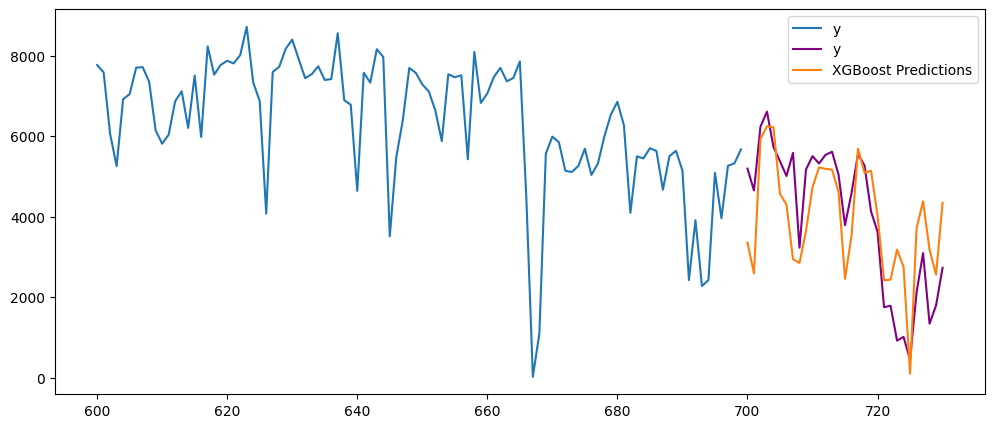

In [261]:
train.loc[600:,'y'].plot(figsize=(12, 5),legend=True)
test.loc[600:,'y'].plot(figsize=(12, 5),legend=True,color = 'purple')
pred_xgb.plot(figsize=(12, 5),legend=True)

### 2.6.2 Metrics

In [262]:
metrics_xgb = metrics(test.y, pred_xgb, 'XGBoost')
metrics_xgb

,Model,mae,rmse,mape
0,XGBoost,970.0,1188.0,41.0


In [263]:
df_metrics = pd.concat([metrics_hotwin,metrics_tbats,metrics_sarimax,metrics_prophet,metrics_xgb],axis=0)
df_metrics.reset_index(drop=True,inplace=True)
df_metrics.sort_values(by=['mae','rmse','mape'],ascending=True,inplace=True)
df_metrics

,Model,mae,rmse,mape
3,Prophet,829.0,1025.0,35.0
4,XGBoost,970.0,1188.0,41.0
2,SARIMAX,1180.0,1480.0,71.0
1,T-BATS,1299.0,1494.0,68.0
0,Hot-winters,1389.0,1698.0,87.0


# 3.0 ensemble

In [273]:
# concat all predictions
pred_prophet.index = pred_hotwin.index
pred_xgb.index = pred_hotwin.index
df_pred = pd.concat([pred_hotwin,pred_tbats,pred_sarimax,pred_prophet,pred_xgb],axis=1)
df_pred.columns = ['Hot-winters','T-BATS','SARIMAX','Prophet','XGBoost']
df_pred

,Hot-winters,T-BATS,SARIMAX,Prophet,XGBoost
2012-12-01,4676.804684,4828.272249,4288.793634,4247.928335,3351.912598
2012-12-02,4153.246795,4482.064414,4216.809763,3576.648546,2590.961914
2012-12-03,4322.003783,4362.513961,5448.119336,5810.965296,5928.902832
2012-12-04,4279.673415,4305.123489,5427.376509,5819.328259,6244.244141
2012-12-05,4825.991667,4260.338328,5448.690983,5519.365748,6217.130859
2012-12-06,4701.723841,4217.321493,4779.471672,5010.527888,4566.909668
2012-12-07,4674.474174,4174.363728,4189.643317,4107.969655,4296.717285
2012-12-08,4575.268886,4131.342400,4177.148691,4352.909991,2943.748291
2012-12-09,4063.077704,4088.294033,4075.809920,3444.574934,2849.083984
2012-12-10,4228.170892,4045.238479,4317.391732,3874.118776,3639.670410


In [280]:
df_pred['mean'] = df_pred.mean(axis=1)
aux = test.y
aux.index = df_pred.index
df_pred['real'] = aux
df_pred

,Hot-winters,T-BATS,SARIMAX,Prophet,XGBoost,mean,real
2012-12-01,4676.804684,4828.272249,4288.793634,4247.928335,3351.912598,4278.742300,5191
2012-12-02,4153.246795,4482.064414,4216.809763,3576.648546,2590.961914,3803.946287,4649
2012-12-03,4322.003783,4362.513961,5448.119336,5810.965296,5928.902832,5174.501042,6234
2012-12-04,4279.673415,4305.123489,5427.376509,5819.328259,6244.244141,5215.149162,6606
2012-12-05,4825.991667,4260.338328,5448.690983,5519.365748,6217.130859,5254.303517,5729
2012-12-06,4701.723841,4217.321493,4779.471672,5010.527888,4566.909668,4655.190912,5375
2012-12-07,4674.474174,4174.363728,4189.643317,4107.969655,4296.717285,4288.633632,5008
2012-12-08,4575.268886,4131.342400,4177.148691,4352.909991,2943.748291,4036.083652,5582
2012-12-09,4063.077704,4088.294033,4075.809920,3444.574934,2849.083984,3704.168115,3228
2012-12-10,4228.170892,4045.238479,4317.391732,3874.118776,3639.670410,4020.918058,5170


<Axes: >

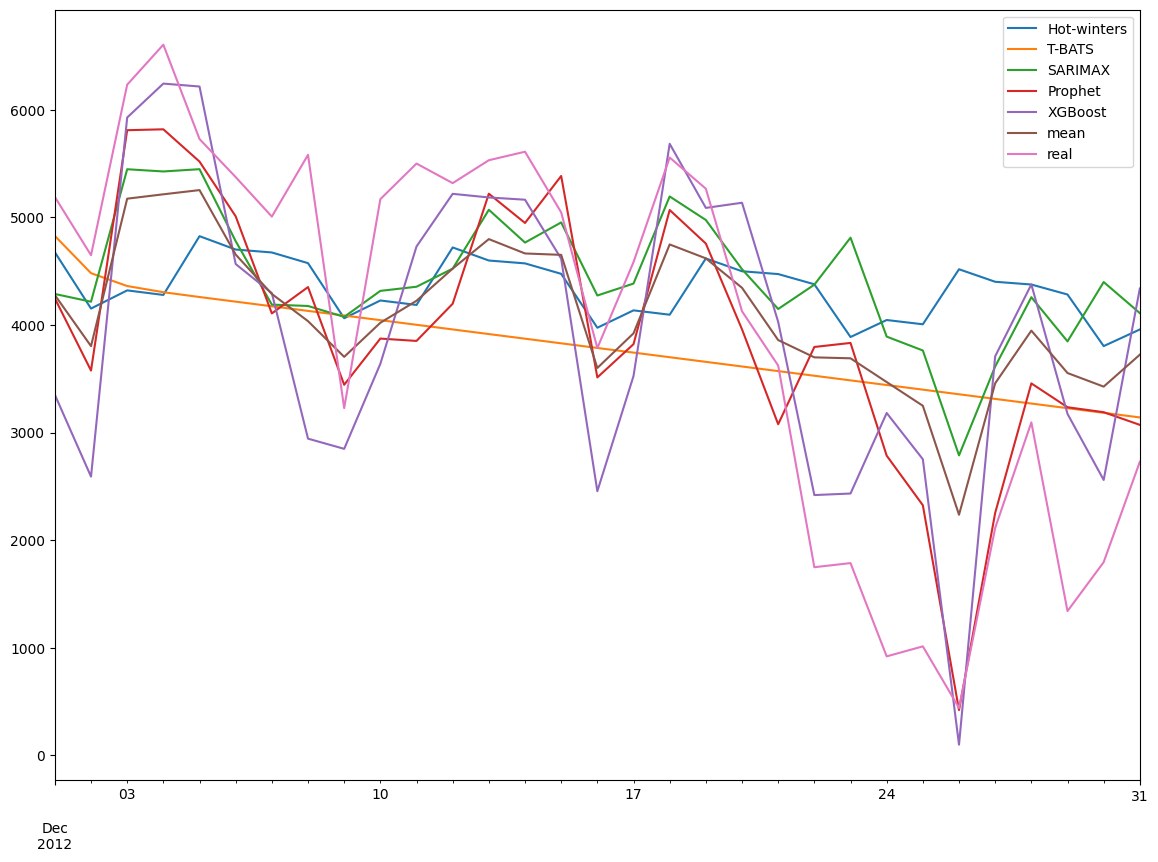

In [285]:
df_pred.plot(figsize=(14,10),legend=True)

## 3.1 metrics

In [276]:
metrics_ensemble = metrics(test.y, df_pred['mean'], 'Ensemble')
metrics_ensemble

,Model,mae,rmse,mape
0,Ensemble,1086.0,1251.0,59.0
